# Experiments Notebook

This notebook documents the experiments conducted for training and evaluating our models on the COVID-19 chest X-ray dataset. It consists of various sections, including dataset loading, training protocol, and model training using different MobileNet variants. We also perform hyperparameter tuning and analyze the trade-offs between accuracy and computational complexity. Finally, we visualize the model's decision-making process using CAM (Class Activation Mapping) and GradCAM (Gradient-weighted Class Activation Mapping) to highlight the regions of the chest X-ray images that the models focus on during predictions.



## Envirnoment Setup

This section installs and imports the necessary libraries, mounts the Google Drive, and navigates to the project directory.

In [ ]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from google.colab import drive

drive.mount('/content/drive')

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/Final_Project/'

/content/drive/.shortcut-targets-by-id/1wKqUB_Y6S42933NPubmLzrmazNFHNQsp/Final_Project


# Dataset Loading

First, let's import the custom functions we created from the `dataset.utils` module to correctly load the dataset. Next, we will load the filenames and remove the images listed in `corrupted_images.txt`, which contains files whose formats failed to be recognized and, therefore, cannot be properly decoded.

In [ ]:
from dataset.utils import load_filenames, class_names, create_dataset

dataset_dir = 'dataset/covid19_dataset'

# Load images
X, Y = load_filenames(dataset_dir)

# Read corrupted_images filenames
with open('./dataset/corrupted_images.txt', 'r') as file:
    corrupted_images = file.readlines()
corrupted_images = [f.strip() for f in corrupted_images]

# Clean the data by removing corrupted images
for f in corrupted_images:
    X.remove(f)

print('Corrupted images removed.')

Loading filenames completed.
Corrupted images removed.


Next, we will divide the loaded filenames into training, validation, and test sets. Afterward, we will use the `create_dataset` function, which creates a `tf.Dataset` object and processes the data through a pipeline that includes preprocessing, caching, data augmentation, shuffling, batching, and prefetching.

In [ ]:
# Train-Validation-Test Split: 0.7, 0.1, 0.2
X_train_val, X_test = train_test_split(X, test_size=0.2, random_state=42)
X_train, X_val = train_test_split(X_train_val, test_size=0.125, random_state=42)

# Dataset creation
batch_size = 16
train_dataset = create_dataset(X_train,
                               batch_size=batch_size,
                               shuffle=True,
                               augment=True,
                               cache_file='/content/train_cache'
                               )
val_dataset = create_dataset(X_val,
                             batch_size=batch_size,
                             shuffle=False,
                             augment=False,
                             cache_file='/content/val_cache'
                             )
test_dataset = create_dataset(X_test,
                              batch_size=batch_size,
                              shuffle=False,
                              augment=False,
                              cache_file='/content/test_cache'
                              )

train_steps = int(np.ceil(len(X_train) / batch_size))
val_steps = int(np.ceil(len(X_val) / batch_size))
test_steps = int(np.ceil(len(X_test) / batch_size))

Dataset correctly created.
Dataset correctly created.
Dataset correctly created.


# Training Protocol

Here, we import all the models we have implemented, including `mobilenet_v1`, `mobilenet_v2`, `se_mobilenet_v1`, `se_mobilenet_v2`, along with some utility functions. Additionally, we define the `train` function, where we outline the training protocol for training the models.

In [ ]:
from models.mobilenet_v1 import mobilenet_v1
from models.mobilenet_v2 import mobilenet_v2
from models.se_net import se_mobilenet_v1, se_mobilenet_v2
from models.utils import compute_flops, save_history_as_json, plot

input_shape = (224, 224, 3)

def train(model, name):

    # Compilare il modello
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    # Definire il callback per ridurre il learning rate
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.1,
                                patience=5,
                                min_lr=1e-4, # rule of thumb -> initial_lr * 1%
                                verbose=1)

    # Definire il callback per salvare il miglior modello
    checkpoint = ModelCheckpoint(filepath=f'./models/weights/{name}.keras',
                                monitor='val_loss',
                                save_best_only=True,
                                verbose=1)

    # Definire il callback per l'early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, start_from_epoch=20, restore_best_weights=True, verbose=1)

    # Addestrare il modello
    history = model.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=80,
                        batch_size=batch_size,
                        steps_per_epoch=train_steps,
                        validation_steps=val_steps,
                        callbacks=[reduce_lr, checkpoint, early_stopping])

    plot(history, save_path=f'./models/figures/{name}.png')
    save_history_as_json(history, f'./models/history/{name}.json')


## Hyperparameter tuning

This section focuses on tuning the initial learning rate through grid search to optimize model performance. We chose `0.01` as the final value.

In [ ]:
# Grid Search

param = {
    'learning_rate': [1e-2, 1e-3, 1e-4],
}
best_accuracy = 0
best_param = {}
history_record = []

epochs = 30
for lr in param["learning_rate"]:
    print(f"Testing with params: lr={lr}")

    model = mobilenet_v1(input_shape)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=lr*0.01, verbose=0)

    history = model.fit(train_dataset,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=val_dataset,
                        steps_per_epoch=train_steps,
                        validation_steps=val_steps,
                        callbacks=[reduce_lr])

    history_record.append(history)
    val_accuracy = max(history.history['val_accuracy'])
    print(f"Validation accuracy: {val_accuracy}")

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_param["learning_rate"] = lr

print(f"Best params: {best_param} with validation accuracy: {best_accuracy}")

Testing with params: lr=0.01
Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 327s 3s/step - accuracy: 0.6781 - loss: 1.1597 - val_accuracy: 0.6625 - val_loss: 0.7978 - learning_rate: 0.0100
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 258ms/step - accuracy: 0.8020 - loss: 0.4360 - val_accuracy: 0.6667 - val_loss: 0.8222 - learning_rate: 0.0100
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 258ms/step - accuracy: 0.7882 - loss: 0.4437 - val_accuracy: 0.6625 - val_loss: 0.7429 - learning_rate: 0.0100
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 241ms/step - accuracy: 0.8113 - loss: 0.4295 - val_accuracy: 0.5292 - val_loss: 0.8420 - learning_rate: 0.0100
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 254ms/step - accuracy: 0.8340 - loss: 0.3828 - val_accuracy: 0.8083 - val_loss: 0.5641 - learning_rate: 0.0100
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 257ms/step - accuracy: 0.8468 - loss: 0.3470 - val_accuracy: 0.6750 - val_loss: 3.6129 - learning_rate: 0.0100
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s

In [ ]:
for i, history in enumerate(history_record):
    save_history_as_json(history, f'./models/history/gr_search_{i+1}.json')

History saved as ./models/history/gr_search_1.json
History saved as ./models/history/gr_search_2.json
History saved as ./models/history/gr_search_3.json


lr=0.01


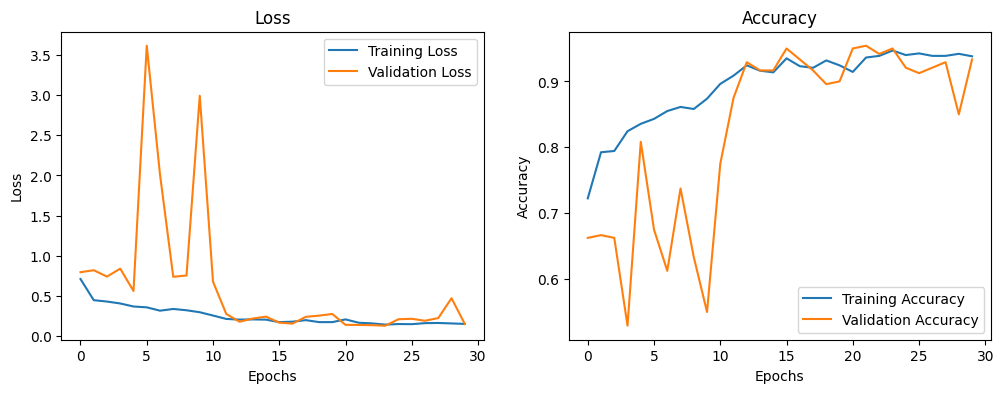

lr=0.001


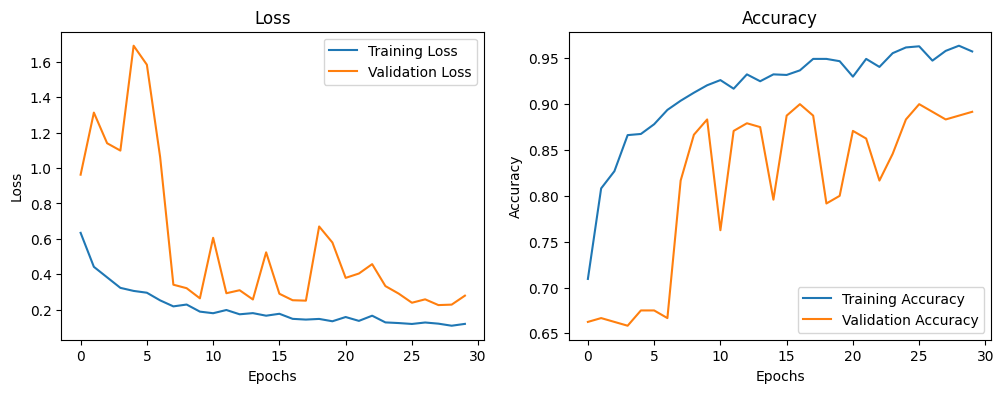

lr=0.0001


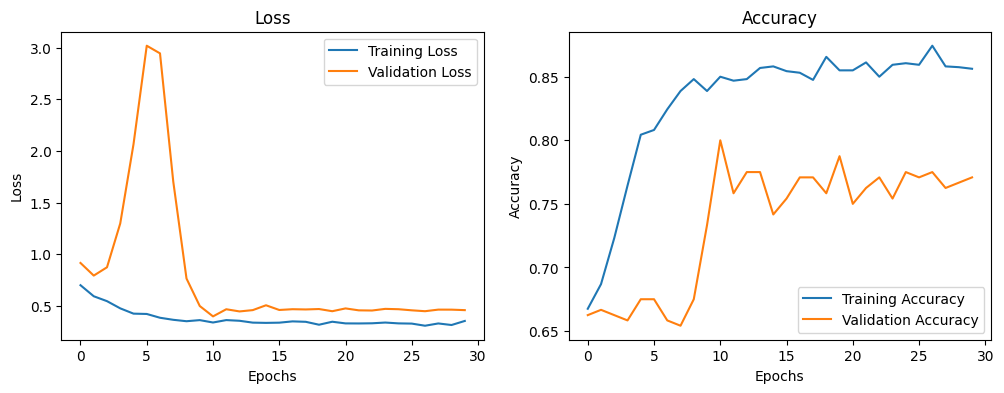

In [ ]:
for lr, history in zip(param["learning_rate"],history_record):
    print(f"lr={lr}")
    plot(history)

## Model training

We train the models using different alpha values, which adjust the width of the MobileNet architectures, following the previously defined training protocol.

Epoch 1/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6465 - loss: 0.7088
Epoch 1: val_loss improved from inf to 0.72939, saving model to ./models/weights/0.25-MobileNetV1-224__.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 339s 3s/step - accuracy: 0.6472 - loss: 0.7076 - val_accuracy: 0.6625 - val_loss: 0.7294 - learning_rate: 0.0100
Epoch 2/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7812 - loss: 0.4690
Epoch 2: val_loss improved from 0.72939 to 0.69160, saving model to ./models/weights/0.25-MobileNetV1-224__.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 212ms/step - accuracy: 0.7812 - loss: 0.4691 - val_accuracy: 0.6667 - val_loss: 0.6916 - learning_rate: 0.0100
Epoch 3/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.7712 - loss: 0.4724
Epoch 3: val_loss did not improve from 0.69160
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 215ms/step - accuracy: 0.7714 - loss: 0.4721 - val_accuracy: 0.6625 - val_loss: 1.4678 - learning_rate: 0.0100
Epoch 4/80
100/100 ━━━━━━━━━━━━━━━━━━━

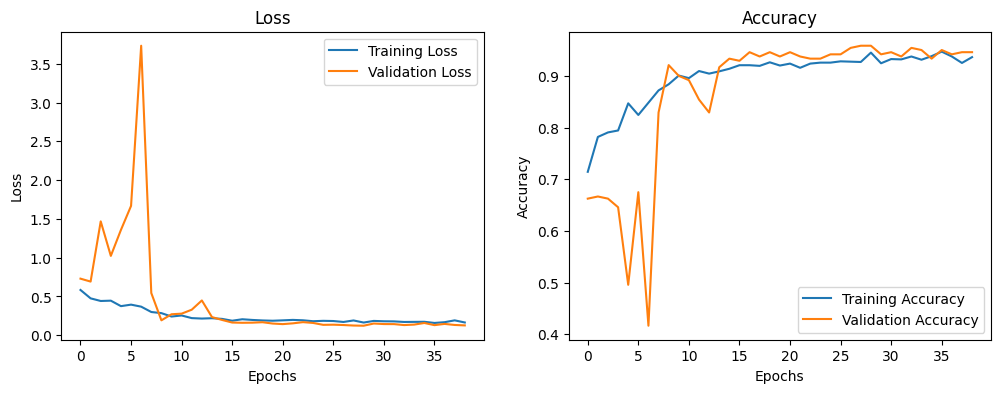

In [ ]:
alpha_values = [1.0, 0.75, 0.5, 0.25]

for alpha in alpha_values:

    model = mobilenet_v1(input_shape, alpha=alpha)
    name = f'{alpha}-MobileNetV1-224'

    train(model, name)

# Models comparison

In this section, we evaluated the performance of the trained models, focusing on the trade-offs between accuracy and computational cost across various model configurations. The evaluation metrics include Top-1 Accuracy, Precision, Recall, and F1-Score to assess model performance, along with the number of parameters and Multiply-Adds (Mult-Adds) to measure model complexity.

In [ ]:
alpha_values = [1.0, 0.75, 0.5, 0.25]
model_names = ['MobileNetV1', 'MobileNetV2', 'SE-MobileNetV1', 'SE-MobileNetV2']
models_to_load = []

for name in model_names:
    for alpha in alpha_values:
        models_to_load.append(f'{alpha}-{name}-224.keras')

print(models_to_load)

['1.0-MobileNetV1-224.keras', '0.75-MobileNetV1-224.keras', '0.5-MobileNetV1-224.keras', '0.25-MobileNetV1-224.keras', '1.0-MobileNetV2-224.keras', '0.75-MobileNetV2-224.keras', '0.5-MobileNetV2-224.keras', '0.25-MobileNetV2-224.keras', '1.0-SE-MobileNetV1-224.keras', '0.75-SE-MobileNetV1-224.keras', '0.5-SE-MobileNetV1-224.keras', '0.25-SE-MobileNetV1-224.keras', '1.0-SE-MobileNetV2-224.keras', '0.75-SE-MobileNetV2-224.keras', '0.5-SE-MobileNetV2-224.keras', '0.25-SE-MobileNetV2-224.keras']


In [ ]:
from tensorflow.keras.metrics import Precision, Recall, Accuracy, Mean

models_dir = "./models/weights/"

accuracy_results = []
precision_results = []
recall_results = []
f1_results = []
num_params = []
flops = []

for name in models_to_load:

    model = tf.keras.models.load_model(models_dir+name)

    accuracy_metric = Accuracy()
    precision_metric = Precision()
    recall_metric = Recall()
    f1_metric = Mean(name='f1_score')

    step = 0
    for X_batch, y_true in test_dataset:
        y_pred = model(X_batch)
        y_pred_classes = tf.argmax(y_pred, axis=1)
        y_true_classes = y_true

        accuracy_metric.update_state(y_true_classes, y_pred_classes)
        precision_metric.update_state(y_true_classes, y_pred_classes)
        recall_metric.update_state(y_true_classes, y_pred_classes)

        precision = precision_metric.result().numpy()
        recall = recall_metric.result().numpy()
        f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        f1_metric.update_state(f1)

        step += 1
        if step == test_steps:
          break

    accuracy = float(accuracy_metric.result().numpy())
    precision = float(precision_metric.result().numpy())
    recall = float(recall_metric.result().numpy())
    f1 = float(f1_metric.result().numpy())

    accuracy_results.append(accuracy)
    precision_results.append(precision)
    recall_results.append(recall)
    f1_results.append(f1)
    num_params.append(model.count_params())
    flops.append(compute_flops(model))

    print(f"Model: {name.split('.keras')[0].ljust(24)} | Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}")

results_dict = {
    "models": models_to_load,
    "accuracy": accuracy_results,
    "precision": precision_results,
    "recall": recall_results,
    "f1-score": f1_results,
    "num_params": num_params,
    "flops": flops
}

with open("./models/evaluation_results.json", "w") as json_file:
    json.dump(results_dict, json_file, indent=4)

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


Model: 1.0-MobileNetV1-224      | Accuracy: 0.9741 | Precision: 0.9735 | Recall: 0.9484 | F1 Score: 0.9614
Model: 0.75-MobileNetV1-224     | Accuracy: 0.9634 | Precision: 0.9539 | Recall: 0.9355 | F1 Score: 0.9157
Model: 0.5-MobileNetV1-224      | Accuracy: 0.9569 | Precision: 0.9530 | Recall: 0.9161 | F1 Score: 0.9300
Model: 0.25-MobileNetV1-224     | Accuracy: 0.9677 | Precision: 0.9605 | Recall: 0.9419 | F1 Score: 0.9359
Model: 1.0-MobileNetV2-224      | Accuracy: 0.9504 | Precision: 0.9177 | Recall: 0.9355 | F1 Score: 0.9346
Model: 0.75-MobileNetV2-224     | Accuracy: 0.9418 | Precision: 0.9384 | Recall: 0.8839 | F1 Score: 0.8885
Model: 0.5-MobileNetV2-224      | Accuracy: 0.9289 | Precision: 0.9841 | Recall: 0.8000 | F1 Score: 0.8494
Model: 0.25-MobileNetV2-224     | Accuracy: 0.9159 | Precision: 0.9394 | Recall: 0.8000 | F1 Score: 0.8232
Model: 1.0-SE-MobileNetV1-224   | Accuracy: 0.9763 | Precision: 0.9737 | Recall: 0.9548 | F1 Score: 0.9548
Model: 0.75-SE-MobileNetV1-224  | Acc

In [ ]:
# Load previously saved results
with open("./models/evaluation_results.json", "r") as json_file:
    results_dict = json.load(json_file)

# Convert to a pandas dataframe
results = pd.read_json("./models/evaluation_results.json", )

# Add a column for Mult-Adds and remove the FLOPs column
results['mult-adds'] = results['flops'] * 1e-6 / 2
results['num_params'] = results['num_params'] * 1e-6
results['models'] = results['models'].str.split('-224').str[0]
results = results.set_index('models')
results = results.drop(columns=['flops'])

results

,accuracy,precision,recall,f1-score,num_params,mult-adds
models,,,,,,
1.0-MobileNetV1,0.974138,0.973510,0.948387,0.961392,3.242883,575.341378
0.75-MobileNetV1,0.963362,0.953947,0.935484,0.915706,1.843491,330.351217
0.5-MobileNetV1,0.956897,0.953020,0.916129,0.929984,0.836547,152.797601
0.25-MobileNetV1,0.967672,0.960526,0.941935,0.935944,0.222051,42.680529
1.0-MobileNetV2,0.950431,0.917722,0.935484,0.934607,2.280067,323.045074
0.75-MobileNetV2,0.941810,0.938356,0.883871,0.888478,1.311483,189.636637
0.5-MobileNetV2,0.928879,0.984127,0.800000,0.849352,0.608611,91.326313
0.25-MobileNetV2,0.915948,0.939394,0.800000,0.823244,0.171451,28.114102
1.0-SE-MobileNetV1,0.976293,0.973684,0.954839,0.954795,3.701635,576.502593


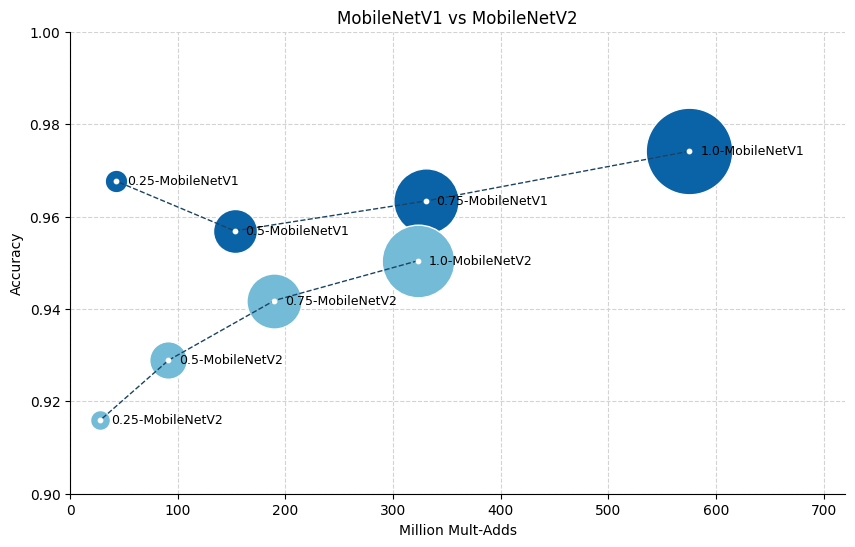

In [ ]:
# Define custom colors
(BLUE_1, BLUE_2, BLUE_3, BLUE_4) = ('#194465', '#0b63a7', '#73bbd6', '#cddff3')
# Defince palette
palette = [BLUE_1, BLUE_2, BLUE_3, BLUE_4]

plt.figure(figsize=(10, 6))

idxs = range(8)
x = results['mult-adds'][idxs]
y = results['accuracy'][idxs]
z = results['num_params'][idxs]

for i in idxs:
    # Plot the bubble
    plt.scatter(x[i], y[i], color=palette[i//4+1], s=z[i]*1200, alpha=1.0, edgecolors='w', zorder=2)
    # Add a white dot in the center of each bubble
    plt.scatter(x[i], y[i], s=10, color='white', zorder=3)
    # Add labels
    plt.text(x[i] + 10, y[i] + 0, results.models[i], fontsize=9, ha='left', va='center')

for i in [0, 4]:
    plt.plot(x[i:i+4], y[i:i+4], "--", color=BLUE_1, lw=1)

plt.title('MobileNetV1 vs MobileNetV2')
plt.xlabel('Million Mult-Adds')
plt.ylabel('Accuracy')
# Set limits for axes
plt.xlim(0, 720.0)
plt.ylim(0.90, 1.0)
# Remove the top and right spines (box lines)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# Set grid with light gray dashed lines
plt.grid(True, which='both', linestyle='--', linewidth=0.8, color='lightgrey', zorder=0)

plt.savefig('./models/figures/Comparison.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

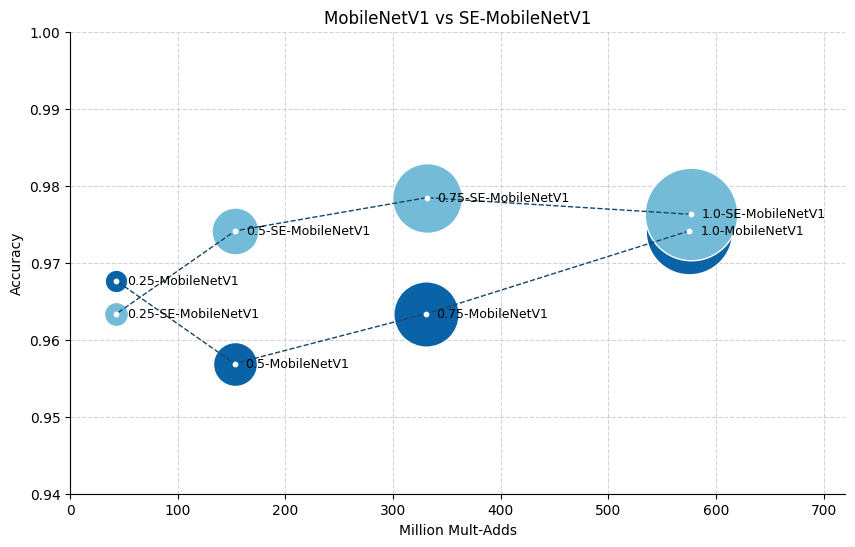

In [ ]:
plt.figure(figsize=(10, 6))

idxs = [0,1,2,3,8,9,10,11]
x = results['mult-adds']
y = results['accuracy']
z = results['num_params']

for i in idxs:
    # Plot the bubble
    plt.scatter(x[i], y[i], color=palette[i//8+1], s=z[i]*1200, alpha=1.0, edgecolors='w', zorder=2)
    # Add a white dot in the center of each bubble
    plt.scatter(x[i], y[i], s=10, color='white', zorder=3)
    # Add labels
    plt.text(x[i] + 10, y[i] + 0, results.models[i], fontsize=9, ha='left', va='center')

for i in [0,8]:
    plt.plot(x[i:i+4], y[i:i+4], "--", color=BLUE_1, lw=1)

plt.title('MobileNetV1 vs SE-MobileNetV1')
plt.xlabel('Million Mult-Adds')
plt.ylabel('Accuracy')
# Set limits for axes
plt.xlim(0, 720.0)
plt.ylim(0.94, 1.0)
# Remove the top and right spines (box lines)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# Set grid with light gray dashed lines
plt.grid(True, which='both', linestyle='--', linewidth=0.8, color='lightgrey', zorder=0)
#plt.legend(title="Models", loc="lower right")

plt.savefig('./models/figures/Comparison_2a.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

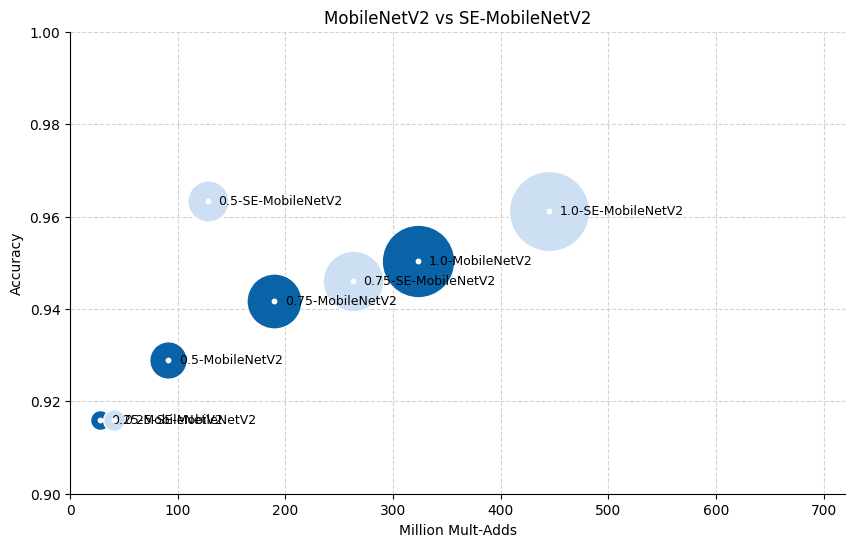

In [ ]:
plt.figure(figsize=(10, 6))

idxs = list(range(4,8)) + list(range(12,16))
x = results['mult-adds']
y = results['accuracy']
z = results['num_params']

for i in idxs:
    # Plot the bubble
    plt.scatter(x[i], y[i], color=palette[i//4], s=z[i]*1200, alpha=1.0, edgecolors='w', zorder=2)
    # Add a white dot in the center of each bubble
    plt.scatter(x[i], y[i], s=10, color='white', zorder=3)
    # Add labels
    plt.text(x[i] + 10, y[i] + 0, results.models[i], fontsize=9, ha='left', va='center')

#for i in [4]:
    #plt.plot(x[i:i+4], y[i:i+4], "-", color=BLUE_1, lw=1)

plt.title('MobileNetV2 vs SE-MobileNetV2')
plt.xlabel('Million Mult-Adds')
plt.ylabel('Accuracy')
# Set limits for axes
plt.xlim(0, 720.0)
plt.ylim(0.90, 1.0)
# Remove the top and right spines (box lines)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# Set grid with light gray dashed lines
plt.grid(True, which='both', linestyle='--', linewidth=0.8, color='lightgrey', zorder=0)
#plt.legend(title="Models", loc="lower right")

plt.savefig('./models/figures/Comparison_2b.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

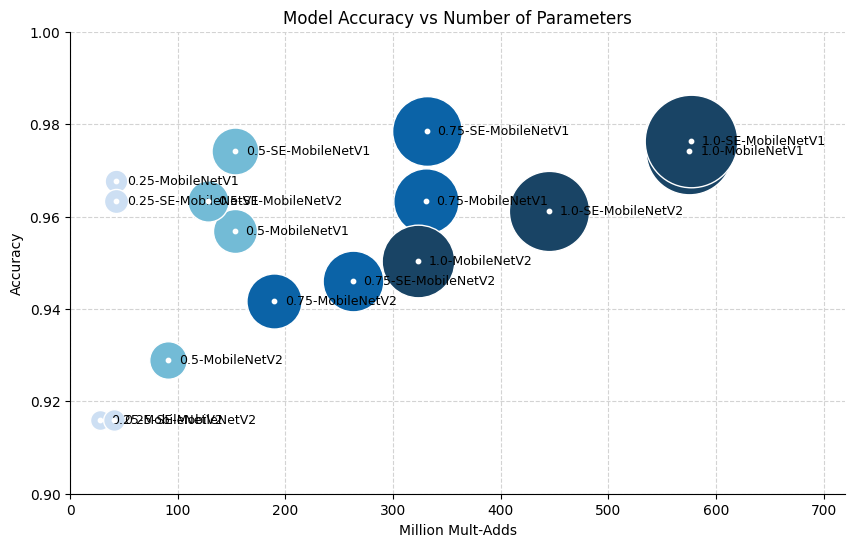

In [ ]:
palette = [BLUE_1, BLUE_2, BLUE_3, BLUE_4]*4

plt.figure(figsize=(10, 6))

idxs = range(16)
x = results['mult-adds'][idxs]
y = results['accuracy'][idxs]
z = results['num_params'][idxs]

for i in idxs:
    # Plot the bubble
    plt.scatter(x[i], y[i], color=palette[i], s=z[i]*1200, alpha=1.0, edgecolors='w', zorder=2)
    # Add a white dot in the center of each bubble
    plt.scatter(x[i], y[i], s=10, color='white', zorder=3)
    # Add labels
    plt.text(x[i] + 10, y[i] + 0, results['models'][i].split('-224')[0], fontsize=9, ha='left', va='center')

plt.title('Model Accuracy vs Number of Parameters')
plt.xlabel('Million Mult-Adds')
plt.ylabel('Accuracy')
# Set limits for axes
plt.xlim(0, 720.0)
plt.ylim(0.90, 1.0)
# Remove the top and right spines (box lines)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# Set grid with light gray dashed lines
plt.grid(True, which='both', linestyle='--', linewidth=0.8, color='lightgrey', zorder=0)
#plt.legend(title="Models", loc="lower right")

plt.savefig('./models/figures/Comparison_3.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

# Class Activation Visualization

To further analyze the behavior of our models, we employed CAM and GradCAM to visualize the areas of the chest X-rays that the networks focused on when making their predictions.

In [ ]:
def make_cam_heatmap(img, model, last_conv_layer_name):
    # First, we create a model that maps the input image to the activations of the last conv layer
    cam_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(last_conv_layer_name).output)

    # Then, we compute the activations of the last conv layer
    activation = cam_model.predict(img[tf.newaxis, ...])

    # This is a vector where each entry is the mean intensity of the activation over a specific feature map channel
    weights = tf.reduce_mean(activation, axis=(0, 1, 2))
    weights = tf.reshape(weights, shape=(1, 1, 1, -1))

    # We multiply each channel in the feature map array by "how important this channel is"
    # Then sum all the channels to obtain the heatmap class activation
    heatmap = tf.reduce_sum(activation * weights, axis=-1)
    heatmap = tf.squeeze(heatmap, axis=0)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap

def display_cam(img, heatmap, alpha=0.4, cam_path=None):

    # Rescale heatmap to a range 0-255
    img = np.uint8(255 * img)
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    if cam_path:
        superimposed_img.save(cam_path)

    # Display CAM
    return superimposed_img


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


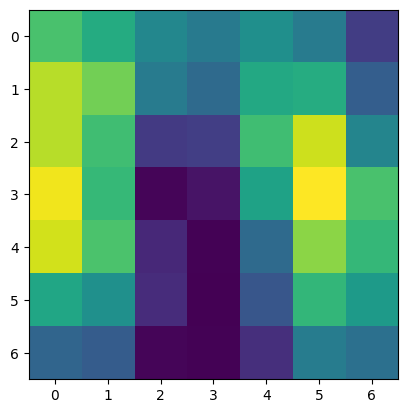

In [ ]:
for image_batch, label_batch in test_dataset.take(1):
    image = image_batch[0]

model = tf.keras.models.load_model("./models/weights/1.0-MobileNetV1-224.keras")
last_conv_layer_name = 'conv_pw_13_relu'

heatmap = make_cam_heatmap(image, model, last_conv_layer_name)

plt.imshow(heatmap)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


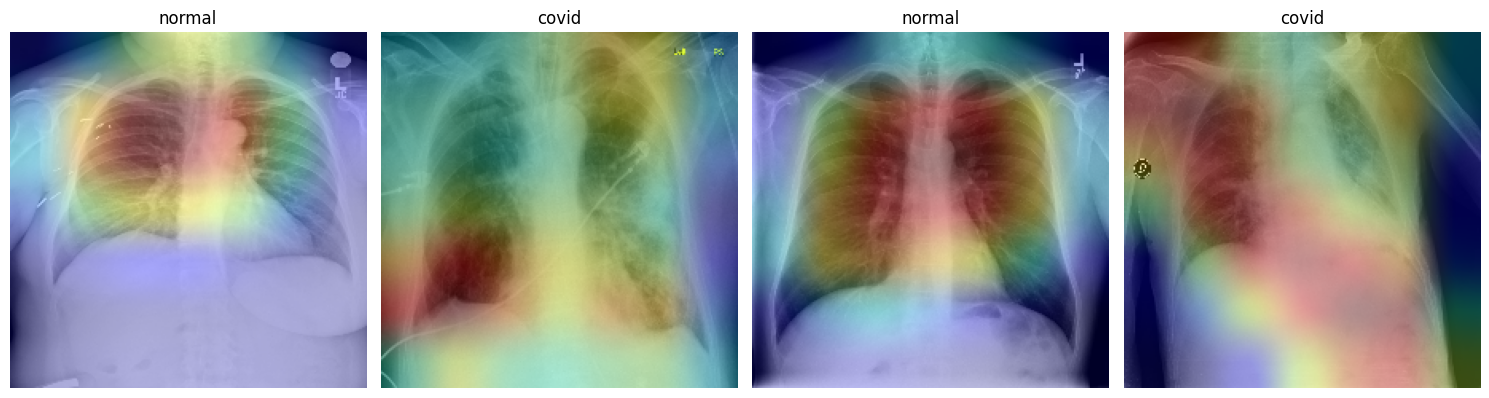

In [ ]:
model = tf.keras.models.load_model("./models/weights/1.0-MobileNetV1-224.keras")
last_conv_layer_name = 'conv_pw_13_relu'

fig, ax = plt.subplots(1, 4, figsize=(15,5))
for image_batch, label_batch in test_dataset.take(1):
    for i in range(4):
        image = image_batch[i+1]
        label = label_batch[i+1]
        heatmap = make_cam_heatmap(image, model, last_conv_layer_name)
        ax[i].imshow(display_cam(image, heatmap))
        ax[i].set_title(class_names[label])
        ax[i].axis('off')
plt.tight_layout()
plt.savefig('./dataset/figures/CAM.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

## GradCAM

[GradCAM Keras Implementation by fchollet](https://keras.io/examples/vision/grad_cam/)

In [ ]:
def make_gradcam_heatmap(img, model, last_conv_layer_name):
    # First, we create a model that maps the input image to the activations of the last conv layer
    grad_model = tf.keras.Model(
        inputs=model.input, outputs=[model.get_layer(last_conv_layer_name).output, model.output]
        )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img[tf.newaxis, ...])
        pred_index = int(tf.argmax(preds[0], axis=1))
        class_channel = preds[0][:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap

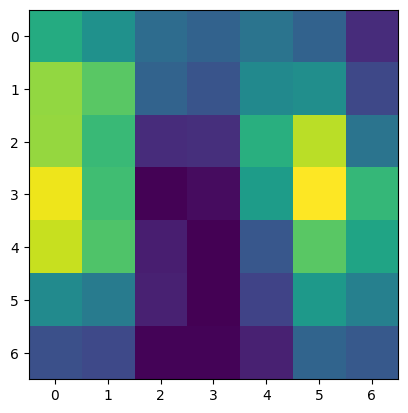

In [ ]:
for image_batch, label_batch in test_dataset.take(1):
    image = image_batch[0]

model = tf.keras.models.load_model("./models/weights/1.0-MobileNetV1-224.keras")
last_conv_layer_name = 'conv_pw_13_relu'

heatmap = make_gradcam_heatmap(image, model, last_conv_layer_name)

plt.imshow(heatmap);

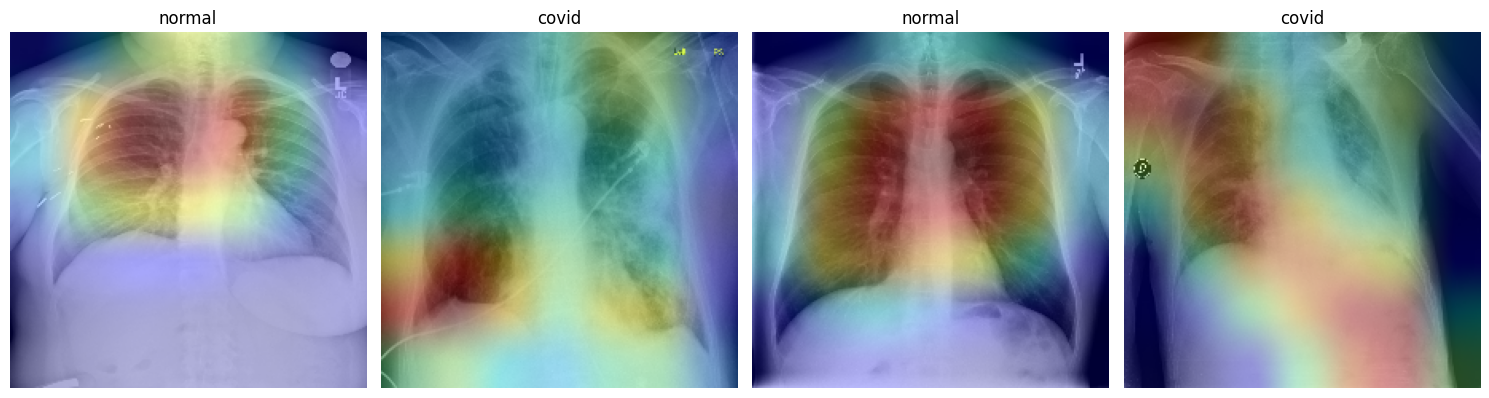

In [ ]:
model = tf.keras.models.load_model("./models/weights/1.0-MobileNetV1-224.keras")
last_conv_layer_name = 'conv_pw_13_relu'

fig, ax = plt.subplots(1, 4, figsize=(15,5))
for image_batch, label_batch in test_dataset.take(1):
    for i in range(4):
        image = image_batch[i+1]
        label = label_batch[i+1]
        heatmap = make_gradcam_heatmap(image, model, last_conv_layer_name)
        ax[i].imshow(display_cam(image, heatmap))
        ax[i].set_title(class_names[label])
        ax[i].axis('off')
plt.tight_layout()
plt.savefig('./dataset/figures/GradCAM.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()